# Taxa de suicídio - Impacto da midia social

- __Descrição__: O dataset explora o impacto do uso das midias sociais relacionadas a taxa de suicidio, segundo fontes de pesquisas e análises estatísticas provisionadas pela Organização Mundial de Saúde (OMS).

- __Features__:

    - **year**: Ano
    - **sex**: Sexo
      - MLE = Masculino
      - FMLE = Feminino
      - BTSX = Ambos os sexos
    - **Suicide Rate % change since 2010**: Evolução da taxa de suicídio desde 2010
    - **Twitter user count % change since 2010**: Evolução de crescimento/declínio de contas cadastradas no Twitter
    - **Facebook user count % change since 2010**: Evolução de crescimento/declínio de contas cadastradas no Facebook

> __Objetivo__: Efetuar análises estatísticas para compreender as correlações entre os índices vinculados
> ao uso de mídias sociais e a taxa de suicidio, extrair casos mais recorrentes de ambos os sexos, analisar a evolução no decorrer dos anos

In [ ]:
import pandas as pd
import numpy as np
import seaborn as srn
import matplotlib.pyplot as plt
%matplotlib inline
from math import ceil
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() #Adiciona conversores personalizados no dicionário global
import warnings
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot
#from sklearn.ensemble import RandomForestClassifier
from pmdarima.arima import auto_arima
from datetime import datetime
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
#from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.formula.api as sm

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df_social = pd.read_csv('./csv files/social-media-impact-on-suicide-rates.csv', encoding='utf-8')
df_social.head()

,year,sex,Suicide Rate % change since 2010,Twitter user count % change since 2010,Facebook user count % change since 2010
0,2010,BTSX,100.000000,100.000000,100.000000
1,2010,FMLE,100.000000,100.000000,100.000000
2,2010,MLE,100.000000,100.000000,100.000000
3,2011,BTSX,98.681894,216.666667,138.980263
4,2011,FMLE,98.183773,216.666667,138.980263


In [4]:
df_ser = pd.Series(df_social.columns)
df_ser

0                                       year
1                                        sex
2           Suicide Rate % change since 2010
3     Twitter user count % change since 2010
4    Facebook user count % change since 2010
dtype: object

In [5]:
df_social.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   year                                     30 non-null     int64  
 1   sex                                      30 non-null     object 
 2   Suicide Rate % change since 2010         30 non-null     float64
 3   Twitter user count % change since 2010   30 non-null     float64
 4   Facebook user count % change since 2010  30 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.3+ KB


In [6]:
df_social = df_social.rename(columns={'Suicide Rate % change since 2010': 'Suicide Rate %',
                          'Twitter user count % change since 2010': 'Twitter user count %',
                          'Facebook user count % change since 2010': 'Facebook user count %'})

In [7]:
df_social.iloc[::4]

,year,sex,Suicide Rate %,Twitter user count %,Facebook user count %
0,2010,BTSX,100.000000,100.000000,100.000000
4,2011,FMLE,98.183773,216.666667,138.980263
8,2012,MLE,98.857511,342.592593,173.684211
12,2014,BTSX,95.848213,533.333333,229.111842
16,2015,FMLE,93.219199,564.814815,261.677632
20,2016,MLE,92.293058,588.888889,305.921053
24,2018,BTSX,88.793600,594.444444,381.578947
28,2019,FMLE,85.269171,629.629630,410.855263


In [8]:
df_social['Suicide Rate %'].describe().apply(
    lambda x: format(x, 'f')
)

count     30.000000
mean      93.837274
std        4.688130
min       85.269171
25%       89.530913
50%       94.478128
75%       98.051267
max      100.000000
Name: Suicide Rate %, dtype: object

In [9]:
df_social['year'].unique(), df_social['sex'].unique()

(array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
       dtype=int64),
 array(['BTSX', 'FMLE', 'MLE'], dtype=object))

In [10]:
df_social.set_index(['year'], inplace=True)

In [11]:
df_social.loc[:, ['sex', 'Suicide Rate %']].head(5)

,sex,Suicide Rate %
year,,
2010,BTSX,100.000000
2010,FMLE,100.000000
2010,MLE,100.000000
2011,BTSX,98.681894
2011,FMLE,98.183773


In [12]:
df_social.isna().sum()

sex                      0
Suicide Rate %           0
Twitter user count %     0
Facebook user count %    0
dtype: int64

# Correlação dos suicidios <--> Uso da midia pelos usuários

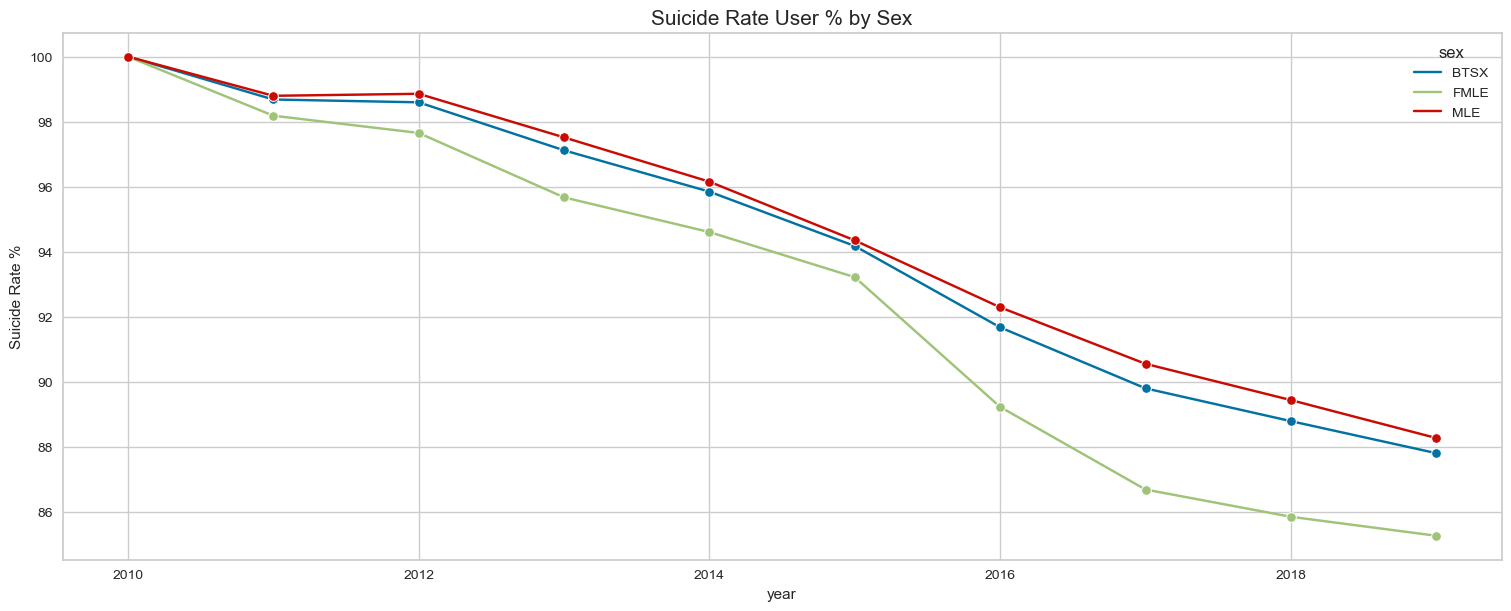

In [13]:
fig, ax = plt.subplots(figsize=(15,6), layout='constrained')
srn.lineplot(data=df_social, x='year', y='Suicide Rate %',
            hue='sex', marker='o')
ax.set_title('Suicide Rate User % by Sex', fontsize=15)
plt.show()

Text(0.5, 1.0, 'Suicide Rate % X Twitter User Count %')

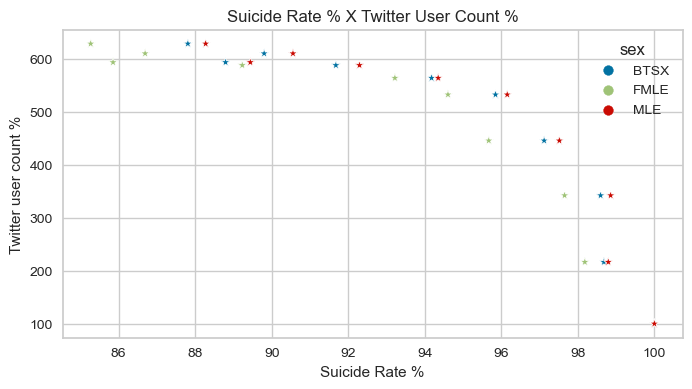

In [14]:
fig = plt.figure(figsize=(8,4))
srn.scatterplot(data=df_social, x='Suicide Rate %', y='Twitter user count %', 
                marker='*', hue='sex')
plt.title('Suicide Rate % X Twitter User Count %')

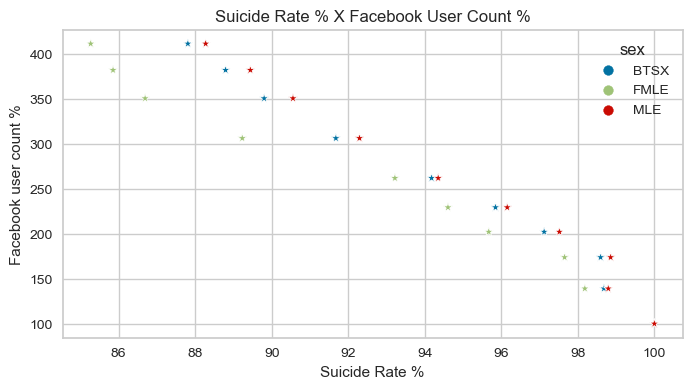

In [15]:
fig = plt.figure(figsize=(8,4))
srn.scatterplot(data=df_social, x='Suicide Rate %', y='Facebook user count %',
               hue='sex', marker='*')
plt.title('Suicide Rate % X Facebook User Count %')
plt.show()

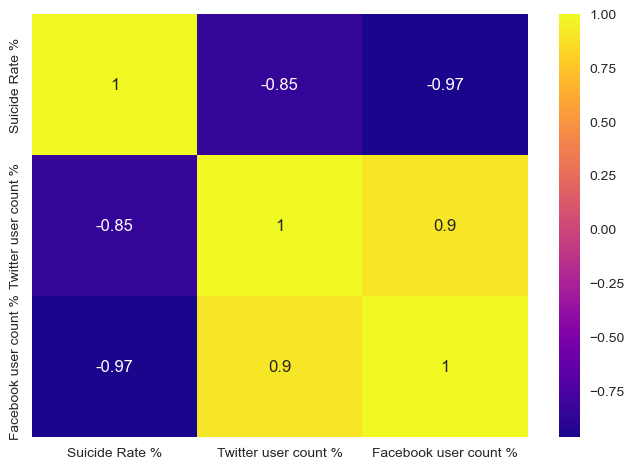

In [16]:
df_numeric = df_social.select_dtypes(include=['number'])
corr_matrix = df_numeric.corr()
srn.heatmap(corr_matrix, annot=True, cmap='plasma', center=0)
plt.show()

In [17]:
x = df_social.iloc[:, 2:4].values
y = df_social['Suicide Rate %'].values

x_train, x_test, y_train, y_test = train_test_split(x,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)

In [18]:
m = LinearRegression().fit(x_train, y_train)
m

LinearRegression()

In [19]:
y_pred = m.predict(x_test)
y_pred

array([86.27992936, 93.69317705, 89.32551455, 93.69317705, 97.37193447,
       96.31091401])

In [20]:
print(f'R2 Score: {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')

R2 Score: 0.9116286968526663
MSE: 1.229292456201046
MAPE: 0.011074179310534194


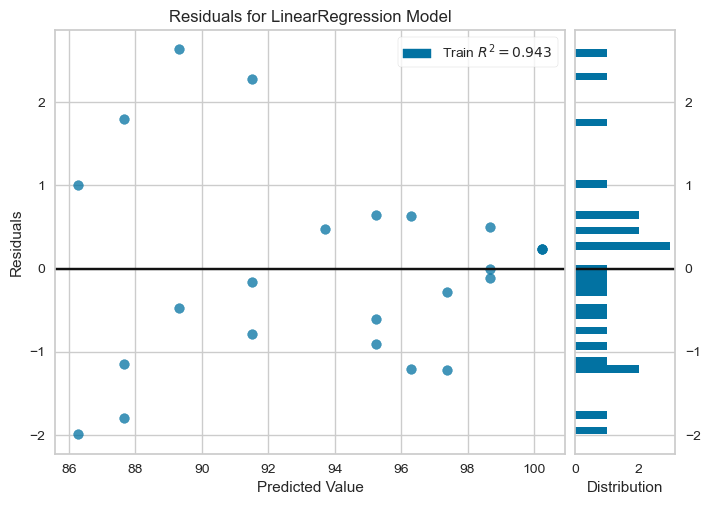

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [21]:
cols_name = ['Twitter user count %', 'Facebook user count %']
ren_cname = [cname.strip().replace(' ', '_') for cname in df_social[cols_name].columns]

#df_social = df_social.rename(columns={
 #   'Twitter user count %': ren_cname[0],
  #  'Facebook user count %': ren_cname[1]
#})

#fixed_model = sm.ols(formula='Twitter_user_count_% ~ Facebook_user_count_%', data=df_social).fit()
#fixed_model.summary()

res_plot = ResidualsPlot(m).fit(x_train, y_train)
res_plot.poof()